In [80]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib
import re
import operator
from functools import reduce

# I/O

## to_excel
https://stackoverflow.com/questions/59216329/how-to-export-the-pandas-conditional-formatting-to-an-excel-file

In [2]:
# Initialize example dataframe
np.random.seed(24)
df = pd.DataFrame({'A': np.linspace(1, 10, 10)})
df = pd.concat([df, pd.DataFrame(np.random.randn(10, 4), columns=list('BCDE'))], axis=1)
df.iloc[0, 2] = np.nan

def highlight_max(s):
    """Styling function: highlights the maximum in a Series yellow."""
    is_max = s == s.max()
    return ['background-color: yellow' if v else '' for v in is_max]

def color_negative_red(val):
    """Styling function: apply red font color to negative values."""
    color = 'red' if val < 0 else 'black'
    return f'color: {color}'

# Apply conditional formatting to dataframe
styled = df.style.applymap(color_negative_red).apply(highlight_max)\
        .format(formatter={'B':'{:.2%}'})
# styled = df.style.format(formatter={'B':'{:.2%}'})


# Export styled dataframe to excel
styled.to_excel('styled.xlsx', engine='xlsxwriter')
# styled.to_excel('styled.xlsx')
styled

,A,B,C,D,E
0,1,132.92%,nan,-0.31628,-0.99081
1,2,-107.08%,-1.43871,0.564417,0.295722
2,3,-162.64%,0.219565,0.678805,1.88927
3,4,96.15%,0.104011,-0.481165,0.850229
4,5,145.34%,1.05774,0.165562,0.515018
5,6,-133.69%,0.562861,1.39285,-0.063328
6,7,12.17%,1.2076,-0.00204021,1.6278
7,8,35.45%,1.03753,-0.385684,0.519818
8,9,168.66%,-1.32596,1.42898,-2.08935
9,10,-12.98%,0.631523,-0.586538,0.29072


# Plot
1. x-axis use 'string': skip weekennds/holidays 
2. x-axis use 'datetime': keep weekends/holidays as gaps

In [3]:
from pandas_datareader import data
# aapl = data.DataReader("AAPL", 
#                        start='2015-1-1', 
#                        end='2015-12-31', 
#                        data_source='yahoo')['Adj Close']
# aapl

#TODO: errors


In [4]:
tickers = ['AAPL', 'SPY', 'VIX']
# ticker = tickers[0]
dat = {ticker: pd.read_csv(Path('./input', f'{ticker}.csv'), index_col=0, parse_dates=True) 
       for ticker in tickers}
retn = {key: val.shift(-1)/val - 1 for key, val in dat.items()}
# retn

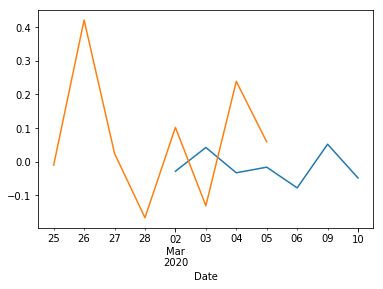

In [22]:
# ax.plot: bar plot messes up axis
df0 = retn['SPY'].loc['2020-03-01':'2020-03-10', 'Close']
df1 = retn['VIX'].loc['2020-02-25':'2020-03-05', 'Close']
df2 = retn['AAPL'].loc['2020-02-15':'2020-03-05', 'Close']

fig, ax = plt.subplots()
df0.plot(ax=ax)
df1.plot(ax=ax)
# df2.plot(kind='bar', ax=ax)

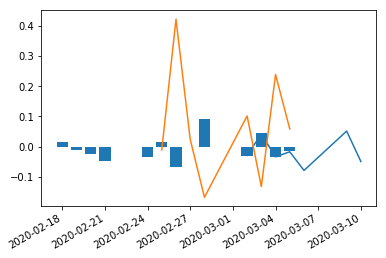

In [94]:
# df.plot: bar plot messes up axis
df0 = retn['SPY'].loc['2020-03-01':'2020-03-10', 'Close']
df1 = retn['VIX'].loc['2020-02-25':'2020-03-05', 'Close']
df2 = retn['AAPL'].loc['2020-02-15':'2020-03-05', 'Close']
dfs = [df0, df1, df2]

# x_type = 'string' 
x_type = 'datetime'
flag_intersect = False
fig, ax = plt.subplots()
if x_type == 'string': 
    xdat = lambda z: [t.strftime('%Y-%m-%d') for t in z]
    # use or_ to fill in NaNs to avoid plotting 'wrappinng around'
    time_func = operator.and_ if flag_intersect else operator.or_ 
    dts = reduce(time_func, [df.index for df in dfs])
    df0, df1, df2 = df0.loc[dts], df1.loc[dts], df2.loc[dts]
elif x_type == 'datetime':       
    xdat =  lambda z: z
ax.plot(xdat(df0.index), df0)
ax.plot(xdat(df1.index), df1)
ax.bar(xdat(df2.index), df2)
fig.autofmt_xdate()
ax.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator('auto'))
# df1.plot(ax=ax)
# df2

# Regular Expressionn

In [73]:
keywords = [' VX1', 'SPX 6M 25D, outright opt', 'VX10', 'VX9', 'SPX 6M 25D delta-hedged forward', 
            'VA2', 'SPX', 'SPX 1M outright', 'SPX 6M delta-hedged cash']
regex = r"VX\d+|6M delta"
regex =r"\b6M\b.*\boutright|\b6M\b.*\bcash\b"
display([re.findall(regex, key) for key in keywords])
display([re.search(regex, key) for key in keywords])

[[], ['6M 25D, outright'], [], [], [], [], [], [], ['6M delta-hedged cash']]

[None,
 <_sre.SRE_Match object; span=(4, 20), match='6M 25D, outright'>,
 None,
 None,
 None,
 None,
 None,
 None,
 <_sre.SRE_Match object; span=(4, 24), match='6M delta-hedged cash'>]